# Model 1 - Logistic Regression

The most basic learning algorithm, perfect for binary classification. My primary goal in this investigation is to figure out a good workflow for training, evaluating, and testing shallow learning models. 

A lot of this work will therefore be experimental.

## Preparing Workspace

In [2]:
import numpy as np
import pandas as pd

# Seed random number generator for consistent OPs across runs
np.random.seed(42)

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import style
style.use('ggplot')

## Loading Data

In [3]:
data = pd.read_csv('./data-final.csv')

In [4]:
data.head()

,CONS_NO,FLAG,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,0387DD8A07E07FDA6271170F86AD9151,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
1,01D6177B5D4FFE0CABA9EF17DAFC2B84,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,4B75AC4F2D8434CFF62DB64D0BB43103,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,10.95,17.95,17.83,17.31,21.44,19.09,18.56,16.25,14.20,13.66
3,B32AC8CC6D5D805AC053557AB05F5343,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
4,EDFC78B07BA2908B3395C4EB2304665E,1,2.9,5.64,6.99,3.32,3.61,5.35,4.73,3.68,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72


## Extracting Features and Targets

In [23]:
# Targets - class labels for all training samples
y = data['FLAG'].values

In [24]:
X = data.iloc[:, 2:].values

In [25]:
# Is there one training sample per label?
assert X.shape[0] == y.shape[0]

## Stratified Sampling 

The dataset has a very large class imbalance - an approximate ~91/9 split between the negative (regular, non-target) and positive (thief, target) classes. 

As such, the model must not only be trained on a subset of the original data with this 91-9 split, but must also be validated for similarly proportioned data.

In [26]:
from sklearn.model_selection import train_test_split

In [31]:
# Shuffling data and making sure both training and test sets contain same proportion of classes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, 
                                                   random_state=42, 
                                                   shuffle=True, 
                                                   stratify=y)

### Visualizing Distributions of Classes

In [32]:
import seaborn as sns

/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:218: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)
/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:218: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)


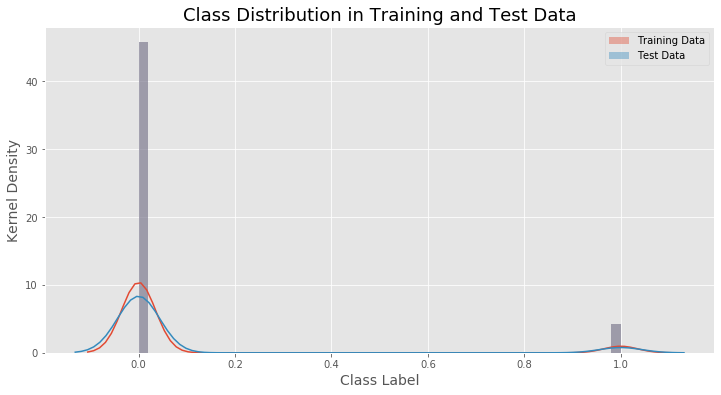

In [94]:
plt.figure(figsize=(12, 6))
sns.distplot(y_train)
sns.distplot(y_test)
plt.legend(['Training Data', 'Test Data'])
plt.xlabel('Class Label', fontsize=14)
plt.ylabel('Kernel Density', fontsize=14)
plt.title('Class Distribution in Training and Test Data', fontsize=18);

### Interpretation

This isn't a great plot. 
- For starters, we're not interested in class labels other than 0.0 and 1.0, but the `distplot` command treats class label as a continuous random variable.
- The histograms also overlap, which means its difficult to see whether the bars representing Training Data's class distribution is lower than or equal to that of Test Data.
- Thirdly, it isn't readily interpretable. I have no idea what Kernel Density is. 

### Making Bar Graphs of Class Label Counts

In [44]:
# Dictionaries of raw counts of class labels
raw_counts = {
    'train': {
        '0': np.count_nonzero(y_train == 0),
        '1': np.count_nonzero(y_train == 1)
    }, 
    'test': {
        '0': np.count_nonzero(y_test == 0),
        '1': np.count_nonzero(y_test == 1)
    }
}

In [68]:
# Repeat for normalized counts
NUM_TRAIN = len(y_train)
NUM_TEST = len(y_test)
NUM_SAMPLES = len(y)

normed_counts = {
    'train': {
        '0': np.count_nonzero(y_train == 0) / NUM_TRAIN,
        '1': np.count_nonzero(y_train == 1) / NUM_TRAIN
    }, 
    'test': {
        '0': np.count_nonzero(y_test == 0) / NUM_TEST,
        '1': np.count_nonzero(y_test == 1) / NUM_TEST
    }
}

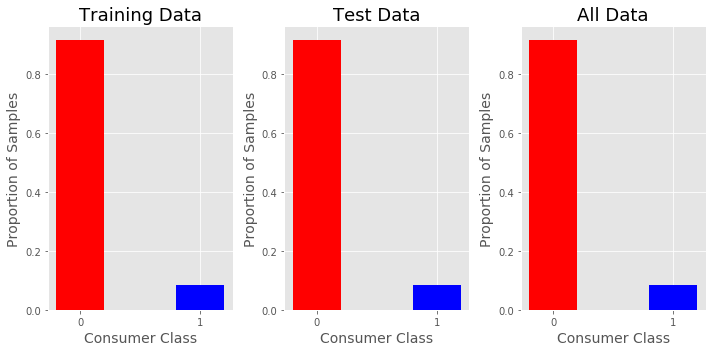

In [83]:
# Comparing train, test, and original data in 3 side-by-side graphs
fig, axes = plt.subplots(ncols=3, figsize=(10, 5), sharey=False)

# First plot - Training Data
plt.sca(axes[0])
plt.bar(x=normed_counts['train'].keys(), height=normed_counts['train'].values(), 
       color=['red', 'blue'], width=0.4)
plt.xlabel('Consumer Class', fontsize=14)
plt.ylabel('Proportion of Samples', fontsize=14)
plt.title('Training Data', fontsize=18)

# Second plot - Test Data
plt.sca(axes[1])
plt.xlabel('Consumer Class', fontsize=14)
plt.bar(x=normed_counts['test'].keys(), height=normed_counts['test'].values(), 
       color=['red', 'blue'], width=0.4)
plt.ylabel('Proportion of Samples', fontsize=14)
plt.title('Test Data', fontsize=18)


# Third plot - All data
plt.sca(axes[2])
plt.xlabel('Consumer Class', fontsize=14)
plt.bar(x=normed_counts['test'].keys(), 
       height=[np.count_nonzero(y == 0) / NUM_SAMPLES, 
               np.count_nonzero(y == 1) / NUM_SAMPLES], 
       color=['red', 'blue'], width=0.4)
plt.ylabel('Proportion of Samples', fontsize=14)
plt.title('All Data', fontsize=18)
plt.tight_layout()

Have confirmed that the `stratify` argument in `train_test_split` has worked as expected: there are equal proportions of both the positive and negative classes in both the training and test data.

Furthermore, these proportions are exactly the same as in the entire dataset prior to the train/test split.

## First Model

### Training

In [70]:
from sklearn.linear_model import LogisticRegression

In [75]:
logReg_1 = LogisticRegression()

In [76]:
logReg_1.fit(X_train, y_train)

/Users/saadmashkoor/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/saadmashkoor/.local/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [80]:
# Did it learn one parameter for each day?
print("Number of parameters learnt: ", len(logReg_1.coef_[0]))

Number of parameters learnt:  1034


### Evaluation

In [95]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

In [85]:
y_pred = logReg_1.predict(X_test)

In [88]:
confusion_matrix(y_test, y_pred)

array([[9304,  385],
       [ 792,  112]])

In [93]:
print(classification_report(y_test, y_pred, target_names=['Regular', 'Thieves']))

              precision    recall  f1-score   support

     Regular       0.92      0.96      0.94      9689
     Thieves       0.23      0.12      0.16       904

   micro avg       0.89      0.89      0.89     10593
   macro avg       0.57      0.54      0.55     10593
weighted avg       0.86      0.89      0.87     10593



In [96]:
roc_auc_score(y_test, y_pred)

0.5420790112316037

## K-Fold Cross Validated Logistic Regression